## XGBoost (cc exg cv)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### load data

In [3]:
with open("./data/train_data/grid_cc.npy", "rb") as fin:
    x_train_grid_cc = np.load(fin)

with open("./data/train_data/grid_exg.npy", "rb") as fin:
    x_train_grid_exg = np.load(fin)
    
with open("./data/train_data/grid_ch.npy", "rb") as fin:
    x_train_grid_ch = np.load(fin)
    
with open("./data/train_data/grid_cv.npy", "rb") as fin:
    x_train_grid_cv = np.load(fin)
    
with open("./data/train_data/yield_train.npy", "rb") as fin:
    y_train = np.load(fin)

In [4]:
print(x_train_grid_cc.shape)
print(x_train_grid_exg.shape)
print(x_train_grid_ch.shape)
print(x_train_grid_cv.shape)
print(y_train.shape)

(7240, 120)
(7240, 120)
(7240, 120)
(7240, 120)
(7240, 1)


In [5]:
with open("./data/test_data/grid_cc.npy", "rb") as fin:
    x_testset_cc = np.load(fin)

with open("./data/test_data/grid_exg.npy", "rb") as fin:
    x_testset_exg = np.load(fin)
    
with open("./data/test_data/grid_ch.npy", "rb") as fin:
    x_testset_ch = np.load(fin)
    
with open("./data/test_data/grid_cv.npy", "rb") as fin:
    x_testset_cv = np.load(fin)
    
with open("./data/test_data/yield_test.npy", "rb") as fin:
    y_testset = np.load(fin)

In [6]:
print(x_testset_cc.shape)
print(x_testset_exg.shape)
print(x_testset_ch.shape)
print(x_testset_cv.shape)
print(y_testset.shape)

(3983, 120)
(3983, 120)
(3983, 120)
(3983, 120)
(3983, 1)


#### yield kg/(100m2) => kg/ha

In [7]:
y_train = y_train / 0.01
y_testset = y_testset / 0.01

### train, validation, and test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def split_train_test(x, y, test_size=0.3):
    x_train, x_valid, y_train, y_valid = train_test_split(
        x, y, test_size=test_size, random_state=42
    )
    x_valid, x_test, y_valid, y_test = train_test_split(
        x_valid, y_valid, test_size=0.5, random_state=43
    )
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [10]:
x_train_grid_cc, x_valid_grid_cc, x_test_grid_cc, y_train_grid_cc, y_valid_grid_cc, y_test_grid_cc = split_train_test(x_train_grid_cc, y_train)

In [11]:
x_train_grid_exg, x_valid_grid_exg, x_test_grid_exg, y_train_grid_exg, y_valid_grid_exg, y_test_grid_exg = split_train_test(x_train_grid_exg, y_train)

In [12]:
x_train_grid_ch, x_valid_grid_ch, x_test_grid_ch, y_train_grid_ch, y_valid_grid_ch, y_test_grid_ch = split_train_test(x_train_grid_ch, y_train)

In [13]:
x_train_grid_cv, x_valid_grid_cv, x_test_grid_cv, y_train_grid_cv, y_valid_grid_cv, y_test_grid_cv = split_train_test(x_train_grid_cv, y_train)

In [14]:
all(y_train_grid_cc == y_train_grid_exg), all(y_train_grid_exg == y_train_grid_ch), all(y_train_grid_ch == y_train_grid_cv)

(True, True, True)

In [15]:
all(y_valid_grid_cc == y_valid_grid_exg), all(y_valid_grid_exg == y_valid_grid_ch), all(y_valid_grid_ch == y_valid_grid_cv)

(True, True, True)

In [16]:
all(y_test_grid_cc == y_test_grid_exg), all(y_test_grid_exg == y_test_grid_ch), all(y_test_grid_ch == y_test_grid_cv)

(True, True, True)

In [17]:
y_train = y_train_grid_cc
y_valid = y_valid_grid_cc
y_test = y_test_grid_cc

### xgboost

In [18]:
import xgboost as xgb

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# max_depth: maximum depth of a tree
#           the model complex the model is, the more likely to overfit
# n_estimators: number of gradient boosted trees
# learning_rate:  boosting learning rate

param_grids = {
    "max_depth": [2, 4, 8, 12],
    "n_estimators": [100, 400, 700],
    "learning_rate": [0.01, 0.015],
}

#### metrics

In [21]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

#### cc, exg, cv

In [22]:
x_train_cxhv = np.concatenate(
    [x_train_grid_cc, x_train_grid_exg, x_train_grid_cv],
    axis=1,
)

x_train_cxhv.shape, y_train.shape

((5068, 360), (5068, 1))

In [23]:
x_valid_cxhv = np.concatenate(
    [x_valid_grid_cc, x_valid_grid_exg, x_valid_grid_cv],
    axis=1,
)

x_valid_cxhv.shape, y_valid.shape

((1086, 360), (1086, 1))

In [24]:
x_test_cxhv = np.concatenate(
    [x_test_grid_cc, x_test_grid_exg,  x_test_grid_cv],
    axis=1,
)

x_test_cxhv.shape, y_test.shape

((1086, 360), (1086, 1))

In [25]:
x_testset_cxhv = np.concatenate(
    [x_testset_cc, x_testset_exg, x_testset_cv],
    axis=1,
)

x_testset_cxhv.shape, y_testset.shape

((3983, 360), (3983, 1))

In [26]:
reg_xgboost = xgb.XGBRegressor(eval_metric="rmse")

In [27]:
search = GridSearchCV(reg_xgboost, param_grid=param_grids, cv=5).fit(x_train_cxhv, y_train)

In [28]:
print(f"the best hyperparameters: {search.best_params_}")

the best hyperparameters: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 700}


In [29]:
reg_xgboost =  xgb.XGBRegressor(
    learning_rate = search.best_params_["learning_rate"],
    n_estimators = search.best_params_["n_estimators"],
    max_depth = search.best_params_["max_depth"],
    eval_metric="rmse",
)

In [30]:
reg_xgboost.fit(x_train_cxhv, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [31]:
valid_pred = reg_xgboost.predict(x_valid_cxhv)
test_pred = reg_xgboost.predict(x_test_cxhv)
cross_year_pred = reg_xgboost.predict(x_testset_cxhv)

In [32]:
print(f"valid rmse:      {np.sqrt(mean_squared_error(y_valid, valid_pred)):.3f}")
print(f"test rmse:       {np.sqrt(mean_squared_error(y_test, test_pred)):.3f}")
print(f"cross year rmse: {np.sqrt(mean_squared_error(y_testset, cross_year_pred)):.3f}")

valid rmse:      121.928
test rmse:       122.178
cross year rmse: 292.172


In [33]:
print(f"valid pearsonr: {pearsonr(np.squeeze(y_valid), valid_pred)[0]:.3f}")
print(f"test pearsonr: {pearsonr(np.squeeze(y_test), test_pred)[0]:.3f}")
print(f"cross year pearsonr: {pearsonr(np.squeeze(y_testset), cross_year_pred)[0]:.3f}")

valid pearsonr: 0.938
test pearsonr: 0.939
cross year pearsonr: 0.750


In [34]:
valid_rmse_p = np.sqrt(mean_squared_error(y_valid, valid_pred)) / np.mean(y_valid)
print(f"valid rmse%      {valid_rmse_p * 100:.2f}%")
test_rmse_p = np.sqrt(mean_squared_error(y_test, test_pred)) / np.mean(y_test)
print(f"test rmse%       {test_rmse_p * 100:.2f}%")
cross_year_rmse_p = np.sqrt(mean_squared_error(y_testset, cross_year_pred)) / np.mean(y_testset)
print(f"cross year rmse% {cross_year_rmse_p * 100:.2f}%")

valid rmse%      6.67%
test rmse%       6.62%
cross year rmse% 37.92%


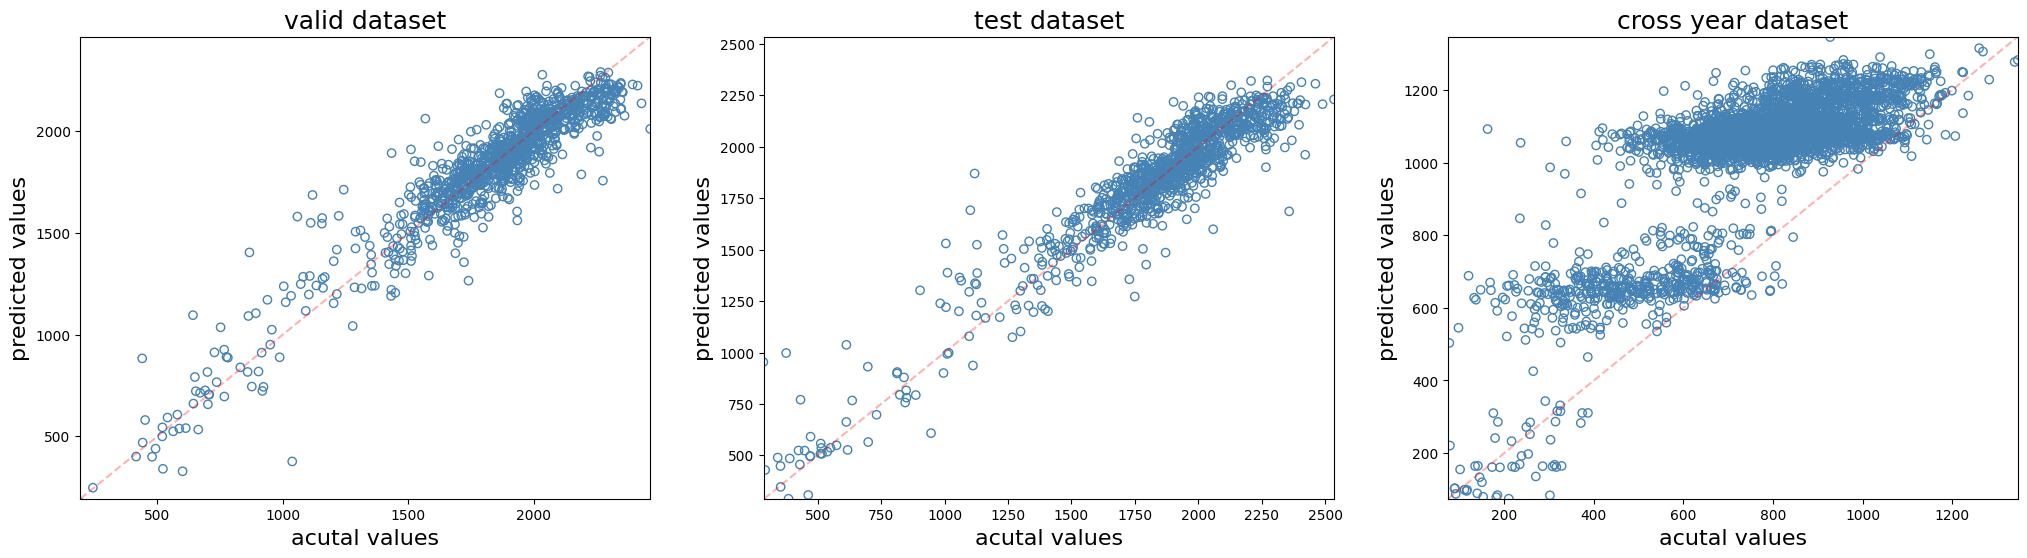

In [35]:
fig, axes = plt.subplots(ncols=3, figsize=(25, 6))

valid_min = np.max([y_valid.min(), valid_pred.min()])
valid_max = np.max([y_valid.max(), valid_pred.max()])
axes[0].scatter(y_valid, valid_pred, facecolors="none", edgecolors="steelblue");
axes[0].set_xlim([valid_min, valid_max])
axes[0].set_ylim([valid_min, valid_max])
axes[0].set_title("valid dataset", fontsize=18);
axes[0].set_xlabel("acutal values", fontsize=16);
axes[0].set_ylabel("predicted values", fontsize=16);
axes[0].plot([valid_min, valid_max], [valid_min, valid_max], linestyle="--", color="red", alpha=0.3);

test_min = np.max([y_test.min(), test_pred.min()])
test_max = np.max([y_test.max(), test_pred.max()])
axes[1].scatter(y_test, test_pred, facecolors="none", edgecolors="steelblue");
axes[1].set_xlim([test_min, test_max])
axes[1].set_ylim([test_min, test_max])
axes[1].set_title("test dataset", fontsize=18);
axes[1].set_xlabel("acutal values", fontsize=16);
axes[1].set_ylabel("predicted values", fontsize=16);
axes[1].plot([test_min, test_max], [test_min, test_max], linestyle="--", color="red", alpha=0.3);

cross_year_min = np.max([y_testset.min(), cross_year_pred.min()])
cross_year_max = np.max([y_testset.max(), cross_year_pred.max()])
axes[2].scatter(y_testset, cross_year_pred, facecolors="none", edgecolors="steelblue");
axes[2].set_xlim([cross_year_min, cross_year_max])
axes[2].set_ylim([cross_year_min, cross_year_max])
axes[2].set_title("cross year dataset", fontsize=18);
axes[2].set_xlabel("acutal values", fontsize=16);
axes[2].set_ylabel("predicted values", fontsize=16);
axes[2].plot([cross_year_min, cross_year_max], [cross_year_min, cross_year_max], linestyle="--", color="red", alpha=0.3);